In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import os
import h5py
import numpy
import pandas as pd
import pylab as plt
from bilby.core.prior import MultivariateGaussian, MultivariateGaussianDist, PriorDict
import numpy as np
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pycbc.conversions as convert
import bilby
import pycbc
import seaborn as sns

## Load FM errors

In [5]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
fm_err_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
#                           'CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_5999_events_pop_from_XPHM_det10.h5')
                           'CE4020ET123_CoBA10_5_PLP_set2_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_5194_events_pop_from_XPHM_det10.h5')
#fm_err_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
#                           'LHI_Asharp_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_5945_events_365_days_pop_from_XPHM_det10.h5')
#                           'LHI_Asharp_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_5233_events_365_days_pop_from_XPHM_det10.h5')

In [6]:
with h5py.File(fm_err_file, 'r') as f:
    print(f.keys())
    print(f['all_inj_params_original'].keys())

<KeysViewHDF5 ['all_inj_params_original', 'cov', 'deriv_variables_in_order', 'errors', 'inj_params', 'netw_snrs', 'sky_locs']>
<KeysViewHDF5 ['PSD_C1', 'PSD_CE20', 'PSD_E1', 'PSD_E2', 'PSD_E3', 'SNR_C1', 'SNR_CE20', 'SNR_E1', 'SNR_E2', 'SNR_E3', 'SNR_mf_C1', 'SNR_mf_CE20', 'SNR_mf_E1', 'SNR_mf_E2', 'SNR_mf_E3', 'SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1', 'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network', 'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower', 'f_ref', 'inclination', 'inv_q', 'log_distance', 'mass1', 'mass2', 'mchirp', 'mtotal', 'old_index', 'phi_12', 'phi_jl', 'polarization', 'q', 'ra', 'redshift', 'spin1_a', 'spin1_azimuthal', 'spin1_polar', 'spin1x', 'spin1y', 'spin1z', 'spin2_a', 'spin2_azimuthal', 'spin2_polar', 'spin2x', 'spin2y', 'spin2z', 'srcmass1', 'srcmass2', '

In [7]:
from utils import load_results_from_h5
fm_results = load_results_from_h5(fm_err_file)

In [8]:
[(key, type(fm_results[key])) for key in fm_results.keys()]

[('all_inj_params_original', dict),
 ('cov', numpy.ndarray),
 ('deriv_variables_in_order', list),
 ('errors', dict),
 ('inj_params', dict),
 ('netw_snrs', numpy.ndarray),
 ('sky_locs', numpy.ndarray)]

In [9]:
for key, val in fm_results.items():
    if isinstance(val, dict):
        fm_results[key] = pd.DataFrame(val)

In [10]:
[(key, type(fm_results[key])) for key in fm_results.keys()]

[('all_inj_params_original', pandas.core.frame.DataFrame),
 ('cov', numpy.ndarray),
 ('deriv_variables_in_order', list),
 ('errors', pandas.core.frame.DataFrame),
 ('inj_params', pandas.core.frame.DataFrame),
 ('netw_snrs', numpy.ndarray),
 ('sky_locs', numpy.ndarray)]

In [11]:
num_events = len(fm_results['cov'])
num_events

5194

In [12]:
fm_results['all_inj_params_original']

,PSD_C1,PSD_CE20,PSD_E1,PSD_E2,PSD_E3,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,SNR_E3,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,122.243884,75.484750,43.787206,36.592811,48.523192,...,-0.258368,-0.026854,-0.107863,15.639841,14.396534,13.060646,30.036374,2.065917,897.063645,1.897294e+09
1,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,36.902874,23.448395,29.025496,28.804783,29.587072,...,0.262877,0.001102,-0.282179,8.753237,8.747526,7.617649,17.500764,2.420633,770.374042,1.911418e+09
2,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,16.102536,9.818106,3.856040,1.116936,3.506747,...,0.155404,0.179745,0.012917,9.921531,2.987733,4.581124,12.909264,1.805138,352.198595,1.909691e+09
3,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,39.464025,29.089591,11.644327,13.645891,12.315546,...,-0.209459,0.014774,-0.359506,7.076466,4.600343,4.944236,11.676810,3.053257,273.301229,1.914589e+09
4,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,74.721286,36.725176,18.494939,15.754001,19.310043,...,0.721567,0.235987,-0.114797,14.469230,9.438874,10.127689,23.908104,0.802954,748.297977,1.894193e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5189,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,11.272460,4.598349,3.777871,4.137692,3.684973,...,0.156666,-0.076569,-0.010607,7.698243,2.284787,3.526062,9.983031,2.164280,1550.373368,1.910505e+09
5190,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,29.233412,18.230858,17.246954,16.587473,16.641270,...,0.048536,0.011817,-0.067514,13.730694,3.680770,5.943081,17.411463,2.059647,1319.276971,1.916952e+09
5191,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,179.953342,99.420797,71.696142,49.457358,32.061578,...,0.223732,-0.106230,0.082505,50.980140,43.226623,40.838989,94.206763,2.897488,1451.686457,1.912961e+09
5192,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,29.440291,10.063842,19.674783,5.459161,19.445174,...,0.062257,0.063935,0.339352,37.142045,32.143061,30.063798,69.285106,1.710928,2491.004492,1.895971e+09


### Divide events into mass categories

In [13]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

In [14]:
mass_ranges = ['<40', '40-80', '>80']
fm_mass_divided = {}
print('Total events =', num_events)
for m_range in mass_ranges:
    fm_mass_divided[m_range] = {}
    selected_idxs = slice_mtotal_pop(fm_results['all_inj_params_original']['srcmtotal'], m_range)
    for key in fm_results.keys():
        if 'variables' in key:
            fm_mass_divided[m_range][key] = fm_results[key]
        else:
            fm_mass_divided[m_range][key] = fm_results[key][selected_idxs]
    print(m_range, '=', len(fm_mass_divided[m_range]['cov']))

Total events = 5194
<40 = 4395
40-80 = 746
>80 = 53


/home/divyajyoti/miniconda3/envs/igwn-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/divyajyoti/miniconda3/envs/igwn-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/divyajyoti/miniconda3/envs/igwn-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


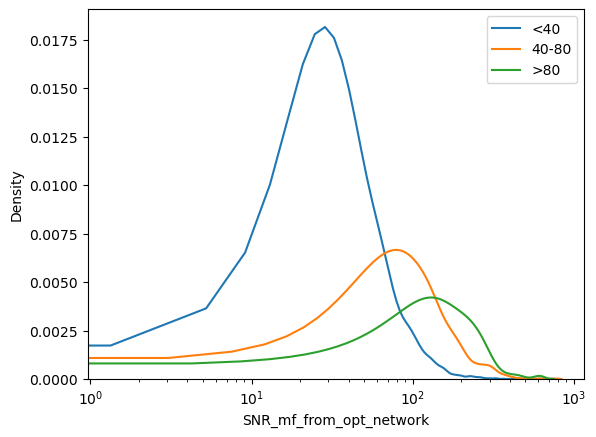

In [15]:
for m_range in fm_mass_divided.keys():
    sns.kdeplot(pd.DataFrame(fm_mass_divided[m_range]['all_inj_params_original'])['SNR_mf_from_opt_network'], 
                label=m_range)
plt.legend(loc=1)
plt.xscale('log')

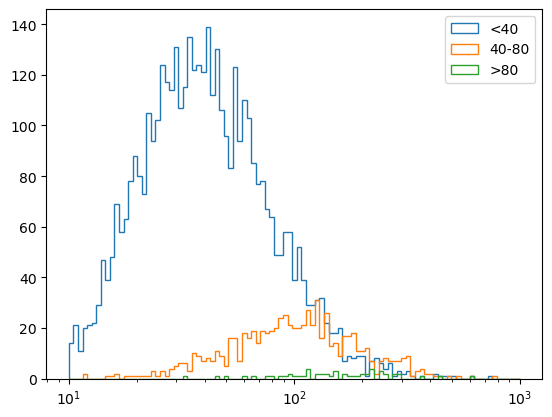

In [18]:
bins=plt.logspace(1, 3, 100)
for m_range in fm_mass_divided.keys():
    plt.hist(pd.DataFrame(fm_mass_divided[m_range]['all_inj_params_original'])['SNR_mf_from_opt_network'], histtype='step',
                label=m_range, bins=bins)
plt.legend(loc=1)
plt.xscale('log')

## Save to h5 file

In [20]:
fm_err_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/CE4020ET123_CoBA10_5_PLP_set2_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_5194_events_pop_from_XPHM_det10.h5'

In [21]:
def mass_range_names(range_name):
    return(range_name.replace('<', 'below_').replace('>', 'above_'))

In [22]:
results_files = {}
for m_range in mass_ranges:
    results_files[m_range] = os.path.join('/'.join(fm_err_file.split('/')[:-1]), 
                                          'mass_bands', 
                                          fm_err_file.split('/')[-1].replace(f'_{num_events}_events', '').replace('.h5',
                                                                                '_'+mass_range_names(m_range)+'.h5'))
results_files

{'<40': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/mass_bands/CE4020ET123_CoBA10_5_PLP_set2_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_pop_from_XPHM_det10_below_40.h5',
 '40-80': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/mass_bands/CE4020ET123_CoBA10_5_PLP_set2_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_pop_from_XPHM_det10_40-80.h5',
 '>80': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/mass_bands/CE4020ET123_CoBA10_5_PLP_set2_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_pop_from_XPHM_det10_above_80.h5'}

In [23]:
from utils import save_results_to_h5

for m_range in mass_ranges:
    save_results_to_h5(fm_mass_divided[m_range], results_files[m_range])